# Final Project DL model Notebook - sinple CNN model with two convolutional layers - v01

#### imports, settings and constants

run log: 

- AWS p2
- full data set
- batch_size = 64
- epochs = 15
- learning_rate = 1e-3
- augmented data enabled
- dynamic lr reduce enabled
- early stopping enabled

In [1]:
import sys

from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dense, Conv2D, MaxPooling2D
from keras.optimizers import Adam
import numpy as np

from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import *

current_dir = Path.cwd()
HOME_DIR = current_dir.parent
DATA_DIR = HOME_DIR.joinpath('data')

# comment out one of the two path options to toggle between sample directory and all data
path = DATA_DIR
# path = DATA_DIR.joinpath('sample')
train_path = path.joinpath('train')
val_path = path.joinpath('valid')
test_path = path.joinpath('test')
results_path = path.joinpath('tesults')

# training variables
batch_size = 64
epochs = 15
learning_rate = 1e-3

Using Theano backend.
Using cuDNN version 5103 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


#### getting training and validation data in batches

In [2]:
batches = get_in_batches(train_path, batch_size=batch_size, augment=True)
val_batches = get_in_batches(val_path, batch_size=batch_size, augment=True)
test_batches = get_in_batches(test_path, batch_size=batch_size)

Found 22424 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


#### and getting the classes, labels and filenames for each batch

In [3]:
trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(batches.classes)
val_labels = onehot(val_batches.classes)
trn_filenames = batches.filenames
val_filenames = val_batches.filenames

#### defining CNN model

In [4]:
model = Sequential([
            BatchNormalization(axis=1, input_shape=(3, 224, 224)),
            Conv2D(32, 3, activation='relu'),
            BatchNormalization(axis=1),
            Conv2D(32, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
    
            Conv2D(64, 3, activation='relu'),
            BatchNormalization(axis=1),
            Conv2D(64, 3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3, 3)),
    
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
    ])
model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 222, 222)      896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 222, 222)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 220, 220)      9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 220, 220)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 73, 73)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 71, 71)        18496     
__________

#### fit_generator() consuming the batches provided by the ImageDataGenerator to fit the model to the data

batches.n = samples in the dataset

batches.batch_size = number of samples in a batch

using batches.n // batches.batch_size ensures we go over the entire dataset once per epoch

validation_steps = number of batches of samples to validate against

In [5]:
history = model.fit_generator(batches,
                    steps_per_epoch=batches.n//batches.batch_size,
                    validation_data=val_batches,
                    validation_steps=1,
                    epochs=epochs,
                    callbacks=[reduce_lr, stop_early])

Epoch 1/15
350/350 [==============================] - 326s - loss: 0.9934 - acc: 0.6800 - val_loss: 1.2440 - val_acc: 0.5938
Epoch 2/15
350/350 [==============================] - 287s - loss: 0.3472 - acc: 0.8914 - val_loss: 0.5076 - val_acc: 0.7969
Epoch 3/15
350/350 [==============================] - 287s - loss: 0.2259 - acc: 0.9288 - val_loss: 0.2318 - val_acc: 0.9062
Epoch 4/15
350/350 [==============================] - 287s - loss: 0.1601 - acc: 0.9501 - val_loss: 0.1735 - val_acc: 0.9219
Epoch 5/15
350/350 [==============================] - 288s - loss: 0.1406 - acc: 0.9563 - val_loss: 0.0924 - val_acc: 0.9688
Epoch 6/15
350/350 [==============================] - 287s - loss: 0.1090 - acc: 0.9669 - val_loss: 0.1899 - val_acc: 0.9375
Epoch 7/15
350/350 [==============================] - 287s - loss: 0.0845 - acc: 0.9734 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 8/15
350/350 [==============================] - 287s - loss: 0.0811 - acc: 0.9757 - val_loss: 0.1117 - val_acc: 0.9688


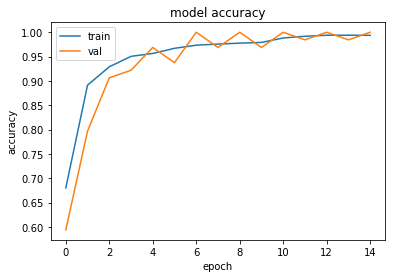

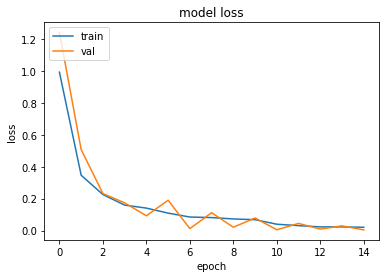

In [6]:
plot_acc_and_loss(history)

#### test performance and plot confusion matrix on one sample batch of 200 images

In [7]:
sample_val_path = DATA_DIR.joinpath('sample/valid')
sam_val_set = get_in_batches(sample_val_path, shuffle=False, class_mode=None, batch_size=200)
pred_classes = model.predict_generator(sam_val_set, 1)
pred_classes = np.argmax(pred_classes, axis=1)
act_classes = sam_val_set.classes

Found 200 images belonging to 10 classes.


[[20  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0]
 [ 1  0  0  0  0 19  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]


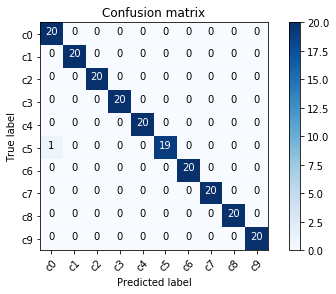

In [8]:
cm = confusion_matrix(act_classes, pred_classes)
plot_confusion_matrix(cm, val_batches.class_indices)
plt.figure()
plt.show()

#### validating the model performance on the val set

Running the evaluate generator returns the cost and accuracy of the model. Doing it in a loop allows us to confirm that the performance is stable. Results should be very similar for all runs. This takes _very_ long though (as long as training or more.. will have to look into this)

In [11]:
rnd_batches = get_in_batches(val_path, batch_size=batch_size, shuffle=True)
val_res = [model.evaluate_generator(rnd_batches, 350) for i in range(5)]
np.round(val_res, 3)

Found 5000 images belonging to 10 classes.


array([[ 0.003,  0.999],
       [ 0.003,  0.999],
       [ 0.003,  0.999],
       [ 0.003,  0.999],
       [ 0.003,  0.999]])

#### saving weights and model separately to file for reuse

In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save('CNN_two_convs_25022918_0900.h5')